# Introduction

This notebook will go through the basic steps of preparing the input and calculating non-local quantities.

# Input

The first step will be the preparation of input data. For this tutorial we assume, that you have been provided with a file containing the DMFT output data. 

We will convert this file to an input file for the `LadderDGA.jl` code and generate a frequency mesh. 

You can also peak into HDF5 files using the Julia HDF5 package.

In [1]:
using HDF5
path_to_input = "/home/julian/Hamburg/lDGA_checks/triangular_test/U2_n1_b12.h5"
f = h5open(path_to_input)

LoadError: unable to determine if /home/julian/Hamburg/lDGA_checks/triangular_test/U2_n1_b12.h5 is accessible in the HDF5 format (file may not exist)

## TRIQS Conversion

If you are starting out with DMFT data from TRIQS, the `triqs_conv.jl` script in the scripts subdirectory of the `LadderDGA.jl` code will responsible for the conversion. This script also utilizes the `SparseVertex` and `EquivalencyClassesConstructor.jl` packages. 

Most of the conversion scripts are built to be called from the command line with the input given as parameters.
In Julia call parameters are stored in the `ARGS` array. Thus, in order to emulate a call with parameters in jupyter notebooks, we will modify this array befor calls to scripts.

We start by adding the path to a triqs output file and a directory for the script output (`@__DIR__` points to the directory the current script runs in) to the `ARGS` array and executing the `triqs_conv.jl` script for this input.
The input file is NOT provided with this example!

If you want to know more about a function, you can type `? function_name` in any cell to view the docstring.

In [2]:
path_to_input = "/home/julian/Hamburg/lDGA_checks/square_test/U2_n1_b12.h5"
path_to_output = "/home/julian/Hamburg/lDGA_checks/square_test"
empty!(ARGS)
push!(ARGS,path_to_input)
push!(ARGS,path_to_output)
include("../scripts/triqs_conv.jl")

Generating freqency mesh with bosonic -59:59, fermionic -60:59 indices
Constructing Array
Starting Computation 3
  1.501402 seconds (142.60 k allocations: 110.212 MiB, 23.20% compilation time)
  0.120951 seconds (54 allocations: 16.165 MiB)
  0.504203 seconds (11 allocations: 78.148 MiB, 2.23% gc time)


## Config File
You will find two new files in the `path_to_output` directory. Before we can start the calculation we need to specify a configuration file which will point `LadderDGA.jl` to these files and provide all necessary parameters.

You will find an example configuration named `config.toml` in the root directory of `LadderDGA.jl`.
`U`, `mu`, `beta`, `nden` and `kGrid` should be set according to your DMFT calculation. The syntax for the `kGrid` parameter is as follows: The grid is given as a string starting with the grid name (see also `Dispersions.jl` for more information), followed by additional parameters, separated by `-`. Currently `2Dsc` and `3Dsc` are available with a single parameter for the hopping to neighbouring sites. Examples are `"2Dsc-0.25"` or `"3Dsc-0.408248"`

Remember to set the `inputDir` and `freqFile` variables to the previously generated files.

# Running the code

The `LadderDGA.jl` code consists of a collection of functions but no linear program flow. This means one has to define a script which defines the actual program flow.
Some examples can be found in the root directory of the project. Here we will go through a typical program flow, also giving us the opportunity to plot quantities at differnts steps of the calculation.
First, point the `cfg_file` variable to your edited configuration file.
We then also tell Julia to use `Plots` and `LadderDGA`.

LadderDGA.jl can be run in parallel by specifying the `path_to_source` variable. If you want to run the single core version, comment out lines `4` to `10` and uncomment line `13`.

In [3]:
cfg_file = "/home/julian/Hamburg/lDGA_checks/square_test/config.toml"
cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/configs/config_50_100_u1_b12.toml"
path_to_source = "/home/julian/Hamburg/LadderDGA.jl"

using Pkg
Pkg.activate(path_to_source; io=devnull)
using LadderDGA
using Plots

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1423


The next step will read the config and input files and set up all variables for you.
The `kGrids` (reduced k grid) arrays contain k grids of the sizes specified in the `Nk` array in your `config.toml`. 
This can be handy for finite size scaling, but for now we will stick with simple calculations and only use a single k grid size.
Finally we will also need to read in the DMFT quantities. `setup_LDGA` will do just that.

Note: the full grids (here stored in the kGrids array) are deprecated. They will be removed from future versions, together with most debug variables (all variables in the return list of `readConfig` after `qGridLoc`).

In [4]:
mP, sP, env, kGridStr = readConfig(cfg_file)
kGStr = kGridStr[1]
impQ_sp, impQ_ch, gImp, qGridLoc, qG, gLoc, GLoc_fft, Σ_loc, FUpDo = setup_LDGA(kGStr, mP, sP, env);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: Could not find E_kin_DMFT, E_pot_DMFT key in input
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:77
┌ Info: setting usable ranges of sp and ch channel from 37:65 and 37:65 to the same range of 37:65
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:147
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(37:65) = 0.3182, χLoc_ch(37:65) = 0.1222
│ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.22019288623927488 ?≈? 0.22019288623927483 ?=? 0.22019288623927483 ?≈? 0.25"
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:171


In [69]:
v1 = reshape(view(gImp, 1, :), LadderDGA.gridshape(qGridLoc))
v2 = reshape(view(gImp, 12, :), LadderDGA.gridshape(qGridLoc))
t = [0.0 + 0.0im, 0.0 + 0.0im]
t2 = LadderDGA.conv_fft(qGridLoc,v1, v2)
LadderDGA.conv_fft!(qGridLoc, t[1:2] ,v1, v2)

1×1×1 Array{ComplexF64, 3}:
[:, :, 1] =
 -4.2212572569493935e-5 + 0.0im

In [70]:
t

2-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im

In [71]:
t2

1×1×1 Array{ComplexF64, 3}:
[:, :, 1] =
 -4.2212572569493935e-5 + 0.0im

We are now in the position to calculate the ladder DGA self energy. The first 5 lines compute all quantities on a lattice of size 1. The resulting self energy is used to cancel out discretization errors and finite size effects in the full self energy.

In [23]:
bubbleLoc = calc_bubble(gImp, qGridLoc, mP, sP)
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, gImp, FUpDo, qGridLoc, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;


bubble = calc_bubble(GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, -mP.U, mP, sP);
nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)
λ_correction!(:sp, impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, qG, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

┌ Warning: currently using min(usable_sp, usable_ch) = min(33:69,33:69) = 33:69 for all calculations. relax this?
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:38
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 33:69, length: 37
│ ch: 33:69, length: 37
│ usable: 33:69, length: 37
│ χch sum = 0.1555378369636489, rhs = 0.28484793551490084
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:47
┌ Info: found 
│   χ_min = -0.09022526652199876
│   ". Looking for roots in intervall $(int)" = . Looking for roots in intervall [-0.09022526652199876, 1.8045053304399752]
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:197
┌ Info: Found λsp 
│   λsp = 0.505751390573883
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:79


# Visualization

The main advantage of calculations in jupyter notebooks are the convenient options for data visualization. The following cells give examples for plotting in Julia

In [13]:
sh = LadderDGA.get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = LadderDGA.kintegrate(qG, nlQ_ch.χ, 2)[:,1]
χch_sum = real(LadderDGA.sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)

sh = LadderDGA.get_sum_helper(nlQ_sp.usable_ω, sP, :b)
χsp_ω = LadderDGA.kintegrate(qG, nlQ_sp.χ, 2)[:,1]
χsp_sum = real(LadderDGA.sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])

0.2848479355149009

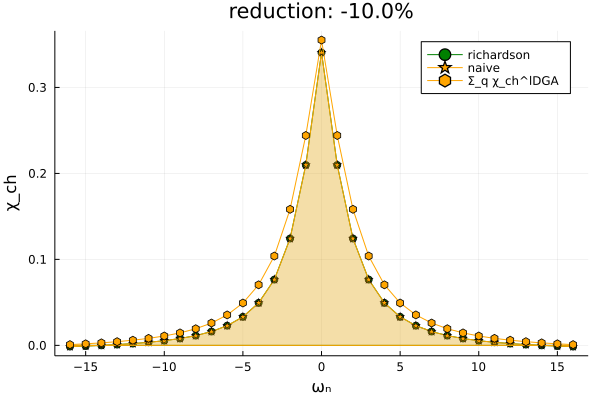

In [44]:
χchED_ω_naive = sum(impQ_ch.χ,dims=[2,3])[:,1,1]/(mP.β^2);
χspED_ω_naive = sum(impQ_sp.χ,dims=[2,3])[:,1,1]/(mP.β^2);

reduction_prct = -0.1
χchED_ω_fit = [LadderDGA.sum_freq(impQ_ch.χ[i,:,:], [1,2], sP.sh_f, mP.β)[1,1] for i in 1:size(impQ_ch.χ,1)];
χspED_ω_fit = [LadderDGA.sum_freq(impQ_sp.χ[i,:,:], [1,2], sP.sh_f, mP.β)[1,1] for i in 1:size(impQ_sp.χ,1)];
usable_ch = LadderDGA.find_usable_interval(real(χchED_ω_fit), reduce_range_prct=reduction_prct)
usable_sp = LadderDGA.find_usable_interval(real(χspED_ω_fit), reduce_range_prct=reduction_prct)
usable_fit_DMFT = intersect(usable_ch, usable_sp)

usable_naive_ch = LadderDGA.find_usable_interval(real(χchED_ω_naive), reduce_range_prct=reduction_prct)
usable_naive_sp = LadderDGA.find_usable_interval(real(χspED_ω_naive), reduce_range_prct=reduction_prct)


plot(usable_ch .- sP.n_iω .- 1, real(χchED_ω_fit[usable_ch]), markershape=:auto, label="richardson", c=:green)
plot!(usable_ch .- sP.n_iω .- 1, repeat([0], length(usable_ch)), fillrange=real(χchED_ω_fit[usable_ch]), fillalpha=0.06, c=:green, label=nothing)

plot!(usable_naive_ch .- sP.n_iω .- 1, real(χchED_ω_naive[usable_naive_ch]), markershape=:auto, label="naive", xlabel="ωₙ", ylabel="χ_ch", c=:orange, title="reduction: $(reduction_prct*100)%")
plot!(usable_naive_ch .- sP.n_iω .- 1, repeat([0], length(usable_naive_ch)), fillrange=real(χchED_ω_naive[usable_naive_ch]), fillalpha=0.3, c=:orange, label=nothing)

plot!(usable_naive_ch .- sP.n_iω .- 1, real(χch_ω[usable_naive_ch]), markershape=:auto, label="Σ_q χ_ch^lDGA", xlabel="ωₙ", ylabel="χ_ch", c=:orange, title="reduction: $(reduction_prct*100)%")

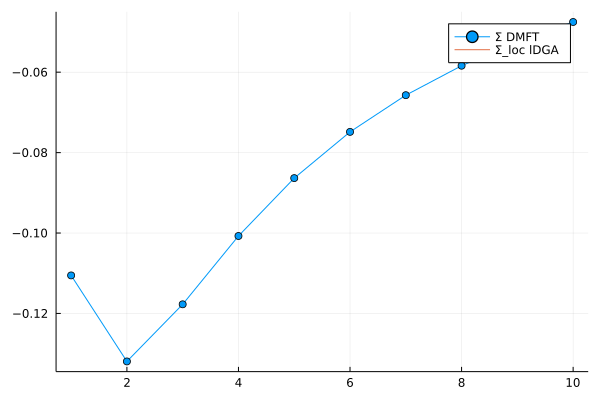

In [30]:
plot(imag.(Σ_loc[1:10]), markershape=:auto, label="Σ DMFT")
plot!(imag.(Σ_ladderLoc[1:10]), markershape=:auto, label="Σ_loc lDGA")

In [31]:
Σ_ladderLoc

1×100 Matrix{ComplexF64}:
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im

In [20]:
Σ_loc

302-element SharedArrays.SharedVector{ComplexF64}:
  0.4999999999999984 - 0.1105392694450873im
   0.499999999999999 - 0.13192956136868228im
  0.4999999999999994 - 0.11772434771219897im
 0.49999999999999917 - 0.10073567126682703im
  0.4999999999999993 - 0.0863406550302086im
 0.49999999999999906 - 0.07484570528200374im
 0.49999999999999883 - 0.06571446996234798im
  0.4999999999999984 - 0.05838969915961156im
                 0.5 - 0.05243190076964499im
                 0.5 - 0.047515894987474105im
  0.5000000000000001 - 0.04340409241476273im
                 0.5 - 0.039922059652681696im
                 0.5 - 0.03694026950184881im
                     ⋮
  0.5000000000000001 - 0.0016434898768977746im
                 0.5 - 0.0016378525677396283im
                 0.5 - 0.0016322537168775852im
                 0.5 - 0.00162669313783681im
 0.49999999999999994 - 0.0016211702565271935im
  0.5000000000000001 - 0.0016156847067065883im
                 0.5 - 0.0016102362372976131im
              

In [33]:
Σ_ladderLoc2,Σ_ladderLoc2_w,tmp = LadderDGA.calc_Σ_dbg(locQ_sp, locQ_ch, bubbleLoc, gImp, FUpDo, qGridLoc, mP, sP)
#Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP.n * mP.U/2.0;

┌ Warning: running out of data for νn = 99 to 99 at ωn = 2, 2
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 99 to 99 at ωn = 3, 3
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 98 to 99 at ωn = 4, 4
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 98 to 99 at ωn = 5, 5
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 97 to 99 at ωn = 6, 6
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 97 to 99 at ωn = 7, 7
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 96 to 99 at ωn = 8, 8
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/ladderDGATools.jl:135
┌ Warning: running out of data for νn = 96 to 99

In [34]:
Σ_ladderLoc2_w

101×100×1 Array{ComplexF64, 3}:
[:, :, 1] =
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+

In [35]:
Σ_ladderLoc2

100×1 Matrix{ComplexF64}:
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
     ⋮
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im
 NaN + NaN*im

In [37]:
maximum(tmp)

0.0

In [40]:
maximum(real.(bubbleLoc))

-0.0